Задачи:

1. - Получить статистику по дням. Посчитать число всех событий по дням, число показов, число кликов, число уникальных объявлений и уникальных кампаний.

2. - Разобраться, почему случился такой скачок 2019-04-05? 

3. - Найти топ 10 объявлений по CTR за все время. CTR — это отношение всех кликов объявлений к просмотрам. Например, если у объявления было 100 показов и 2 клика, CTR = 0.02. Различается ли средний и медианный CTR объявлений в наших данных?

4. - Есть ли различия в CTR у объявлений с видео и без? А чему равняется 95 процентиль CTR по всем объявлениям за 2019-04-04?

5. - Для финансового отчета нужно рассчитать наш заработок по дням. В какой день мы заработали больше всего? В какой меньше? Мы списываем с клиентов деньги, если произошел клик по CPC объявлению, и мы списываем деньги за каждый показ CPM объявления, если у CPM объявления цена 200 рублей, то за один показ мы зарабатываем 200 / 1000.

6. - Какая платформа самая популярная для размещения рекламных объявлений? Сколько процентов показов приходится на каждую из платформ (колонка platform)?

In [1]:
# импортируем библиотеки для удобной работы
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
ads = pd.read_csv("/home/jupyter-m-vosorov/shared/ads_data.csv.zip", compression = "zip") # считываем данные

In [4]:
ads.head()

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id
0,23456,1554076848,view,2019-04-01,CPM,0,5681,23456,android,190.0,125560,793
1,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,1041
2,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,41
3,42987,1554135866,view,2019-04-01,CPM,0,28541,42985,ios,199.1,80160,898
4,23456,1554135866,view,2019-04-01,CPM,0,5681,23456,web,190.0,125560,29


In [5]:
# Задача 1.1:

ads["date"] = pd.to_datetime(ads["date"]) # переводим колнку "date" в более удобный для работы формат datetime

ads \
    .groupby(["date", "event"], as_index = False) \
    .agg({"time" : "count"}) \
    .pivot(index = "date", columns = "event", values = "time").reset_index()
# Количество кликов и просмотров по дням

event,date,click,view
0,2019-04-01,735,34832
1,2019-04-02,1518,145811
2,2019-04-03,1678,214851
3,2019-04-04,1517,126182
4,2019-04-05,501595,1783288
5,2019-04-06,80420,284287


In [6]:
# Задача 1, продолжение
ads \
    .groupby("date", as_index = False) \
    .agg({"ad_id" : "nunique", "campaign_union_id" : "nunique"}) \
    .rename(columns = {"ad_id" : "unique_ads", "campaign_union_id" : "unique_campaigns"})
# Количество уникальных объявлений и рекламных кампаний по дням

,date,unique_ads,unique_campaigns
0,2019-04-01,49,49
1,2019-04-02,146,146
2,2019-04-03,179,177
3,2019-04-04,150,147
4,2019-04-05,131,130
5,2019-04-06,61,60


In [28]:
# Задача 2
# Можно предположить что увелечение количества объявлений связано с новой рекламной кампанией, проверим это, посмотрев
# на количество разных объявлений в день скачка

ads \
    .query("date == '2019-04-05'") \
    .groupby("ad_id", as_index = False) \
    .agg({"time" : "count"}) \
    .rename(columns = {"time" : "number_of_ads"}) \
    .sort_values("number_of_ads", ascending = False)

# Действительно, большую часть скачка формирует только одно объявление с id "112583", оно было показано больше 2 миллионов раз


,ad_id,number_of_ads
108,112583,2166611
27,29927,27186
65,44635,8268
81,46583,7327
66,44956,5656
...,...,...
77,46433,17
17,21405,16
76,46024,16
112,113867,15


In [4]:
# Задача 3:
# Создаю таблицу с количеством просмотров для каждого объявления
ctr_df = ads \
    .query("event == 'view'") \
    .groupby("ad_id", as_index = False) \
    .agg({"time" : "count"}) \
    .rename(columns = {"time" : 'nums_of_views'})
    
# Создаю таблицу с количеством кликов для каждого обьявления
click = ads \
    .query("event == 'click'") \
    .groupby("ad_id", as_index = False) \
    .agg({"time" : "count"}) \
    .rename(columns = {"time" : 'nums_of_clicks'})

# Объединяю таблицы и создаю новую колонку, в которой рассчитываю CTR в процентах
ctr_df = ctr_df.merge(click, on = "ad_id", how = "inner")
ctr_df["CTR"] = (ctr_df["nums_of_clicks"] / ctr_df["nums_of_views"] * 100).round(2)
top_ctr = ctr_df.sort_values("CTR", ascending = False).head(10)
top_ctr

,ad_id,nums_of_views,nums_of_clicks,CTR
251,112583,1934788,580436,30.00
279,119450,1254,258,20.57
110,38575,257,43,16.73
126,40968,217,29,13.36
180,45642,344,42,12.21
245,110924,95,11,11.58
168,45043,245,28,11.43
81,35034,997,112,11.23
4,4585,476,53,11.13
283,120347,2168,236,10.89


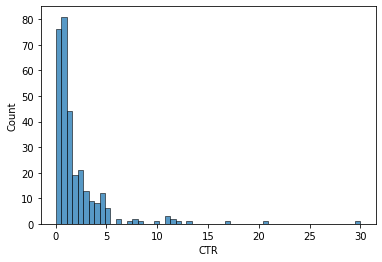

In [5]:
# Также для наглядности можно посмотреть распределение CTR у все объявлений
sns.histplot(ctr_df["CTR"], kde = False)

In [6]:
# Задача 3, продолжение
median = ctr_df["CTR"].median().round(3)
mean = ctr_df["CTR"].mean().round(3)
print(f"CTR median is {median}")
print(f"CTR mean is {mean}")

# Как мы видим медианы и среднее различаются в 2 два раза, это связано с тем, что есть объявления у которых CTR заметно больше
# чем CTR у большинста объявлений. В подобных случаях рациональнее использовать медиану

CTR median is 1.075
CTR mean is 2.063


In [9]:
# Задача 4. Есть ли различия в CTR у объявлений с видео и без?
ads_video = ads.groupby(["ad_id", "has_video"], as_index = False).agg({"time" : "count"})
ads_video = ads_video.merge(ctr_df, on = "ad_id", how = "inner")
ads_video = ads_video.drop(columns = ["time", "nums_of_views", "nums_of_clicks"])
# Получили таблицу с CTR и информацие, есть ли в объявлении видео
ads_video \
    .groupby("has_video", as_index = False) \
    .agg({"CTR" : "median"})
# Расчитали медианное значени СTR(как мы выяснили выше, его использование более рационально) для объявлений с/без видео

# Как мы видим, в среднем объявления без видио успешнее, если судить по CTR

,has_video,CTR
0,0,1.08
1,1,0.24


In [18]:
# Задача 5
# Для начала рассчитаем, сколько мы заработали по дням использую способ оплаты CPM
cpm_money = ads \
    .query("ad_cost_type == 'CPM' & event == 'view'") \
    .groupby("date", as_index = False) \
    .agg({"ad_cost" : "sum"})
cpm_money["ad_cost"] = cpm_money["ad_cost"] / 1000
cpm_money = cpm_money.rename(columns = {"ad_cost" : "money"})
cpm_money

,date,money
0,2019-04-01,6122.812300
1,2019-04-02,26173.305100
2,2019-04-03,34612.317000
3,2019-04-04,19416.356800
4,2019-04-05,354178.548996
5,2019-04-06,56587.337600


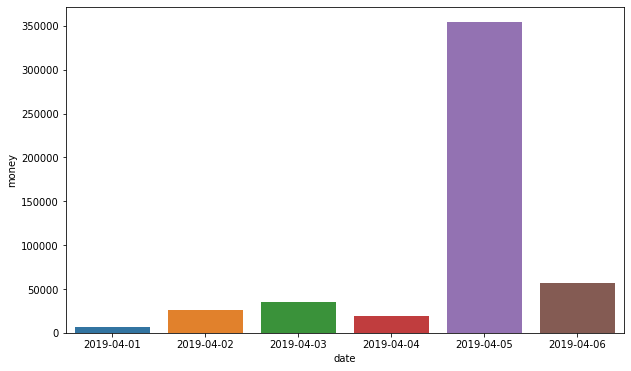

In [20]:
# Также построим график для этой таблицы для наглядности
plt.figure(figsize=(10, 6))
sns.barplot(data = cpm_money, x = "date", y = "money")

In [21]:
# Задача 5, продолжение
# Теперь рассчитаем сколько мы заработали по дням используя способ оплаты CPC
cpc_money = ads \
    .query("ad_cost_type == 'CPC' & event == 'click'") \
    .groupby("date", as_index = False) \
    .agg({"ad_cost" : "sum"})
cpc_money["ad_cost"] = cpc_money["ad_cost"]
cpc_money = cpc_money.rename(columns = {"ad_cost" : "money"})
cpc_money

,date,money
0,2019-04-01,7036.9
1,2019-04-02,7663.7
2,2019-04-03,38597.2
3,2019-04-04,26878.0
4,2019-04-05,4381.2
5,2019-04-06,253.0


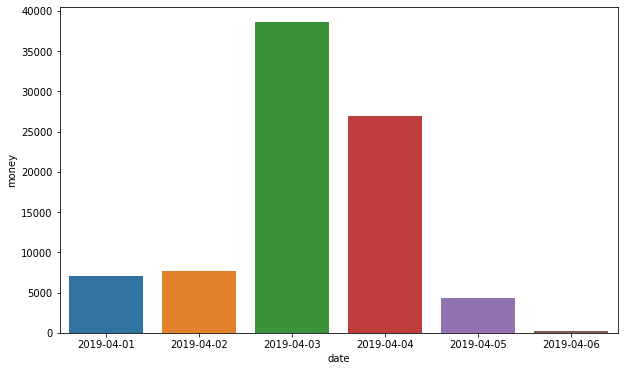

In [23]:
# Для этой таблички тоже сделаем график для наглядности
plt.figure(figsize=(10, 6))
sns.barplot(data = cpc_money, x = "date", y = "money")

In [27]:
# Задача 6
ads.platform.value_counts(normalize = True)
# Как мы видим наиболее популярной платформой является android

android    0.499954
ios        0.300020
web        0.200026
Name: platform, dtype: float64